In [4]:
from modsim import *

In [5]:
from pandas import read_csv

data = read_csv('glucose_insulin.csv', index_col='time');

In [15]:
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


In [7]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

In [8]:
params = G0, k1, k2, k3

In [37]:
def make_system1(params, data):
    G0, k1, k2, k3 = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    Gb = data.glucose[t_0] ## Gb = 92
    Ib = data.insulin[t_0] ## Ib = 11
    I = interpolate(data.insulin)
    
    init = State(G=G0, X=0) ## Functions in the modsim.py library include State, which we are using now.       
                            ## State creates a State object,which is a collection of state variables.
                            ## State objects contain state variables, which represent the state of the
                            ## system, which get updated in the course of a simulation.


    return System(init=init, params=params,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=1)
                ## System objects contain system variables, which represent parameters
                ## of the system, which usually don’t get updated over the course of a
                ## asimulation.

In [38]:
def make_system2(params, data):
    G0, k1, k2, k3 = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    Gb = data.glucose[t_0] ## Gb = 92
    Ib = data.insulin[t_0] ## Ib = 11
    I = interpolate(data.insulin)
    
    init = State(G=G0, X=0) ## Functions in the modsim.py library include State, which we are using now.       
                            ## State creates a State object,which is a collection of state variables.
                            ## State objects contain state variables, which represent the state of the
                            ## system, which get updated in the course of a simulation.


    return System(init=init, params=params,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)
                ## System objects contain system variables, which represent parameters
                ## of the system, which usually don’t get updated over the course of a
                ## asimulation.

In [39]:
system2 = make_system1(params,data)

In [40]:
system = make_system2(params, data)

In [41]:
def update_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [42]:
update_func(system.t_0, system.init, system)

G    262.88
X      0.00
Name: state, dtype: float64

In [43]:
update_func(system2.t_0, system2.init, system2)

G    266.44
X      0.00
Name: state, dtype: float64

In [44]:
def run_simulation(system, update_func):    
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    frame = TimeFrame(index=t_array, 
                      columns=system.init.index)
    frame.iloc[0] = system.init
    
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)
    
    return frame

In [45]:
results = run_simulation(system, update_func)

In [52]:
resultsn = run_simulation(system2, update_func)

In [53]:
results.head()

,G,X
0.0,270.000000,0.000000
2.0,262.880000,0.000000
4.0,256.044800,0.000450
6.0,249.252568,0.004002
8.0,240.967447,0.006062


In [54]:
resultsn.head()

,G,X
0.0,270.000000,0.000000
1.0,266.440000,0.000000
2.0,262.951200,0.000112
3.0,259.502594,0.000335
4.0,256.065544,0.001334


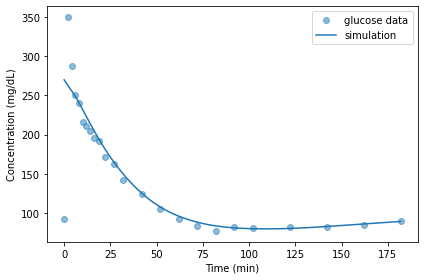

In [55]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data')
results.G.plot(style='-', color='C0', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

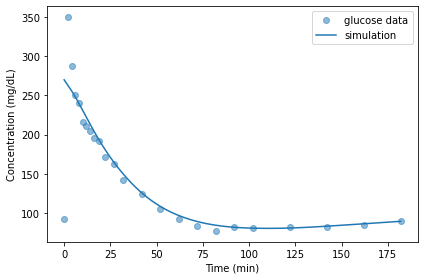

In [56]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data')
resultsn.G.plot(style='-', color='C0', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

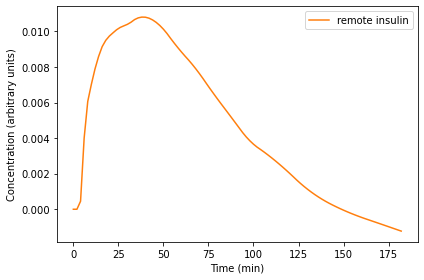

In [57]:
results.X.plot(color='C1', label='remote insulin')
                    ## Remember that X represents the concentration of insulin in the "remote compartment", 
                    ## which is believed to be tissue fluid, so we can't compare it to the measured 
                    ## concentration of insulin in the blood.
decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

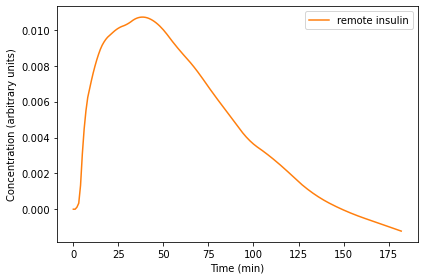

In [58]:
resultsn.X.plot(color='C1', label='remote insulin')
                    ## Remember that X represents the concentration of insulin in the "remote compartment", 
                    ## which is believed to be tissue fluid, so we can't compare it to the measured 
                    ## concentration of insulin in the blood.
decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

In [59]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

In [60]:
results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=results.index)

In [61]:
details.success

True

In [62]:
details.message

'The solver successfully reached the end of the integration interval.'

In [63]:
results2.head()

,G,X
0.0,270.000000,0.000000
2.0,262.980942,0.000240
4.0,255.683455,0.002525
6.0,247.315442,0.005174
8.0,238.271851,0.006602


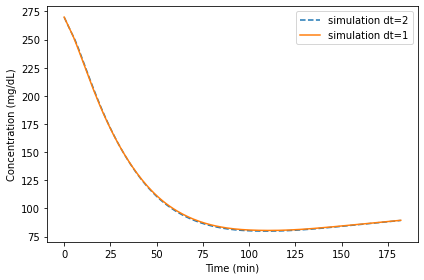

In [64]:
results.G.plot(style='--', label='simulation dt=2')
resultsn.G.plot(style='-', label='simulation dt=1')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [65]:
diff = results.G - resultsn.G
percent_diff = diff / resultsn.G * 100

In [66]:
percent_diff.abs().describe()

count    92.000000
mean      0.527015
std       0.291531
min       0.000000
25%       0.292193
50%       0.505702
75%       0.801698
max       0.970760
Name: G, dtype: float64

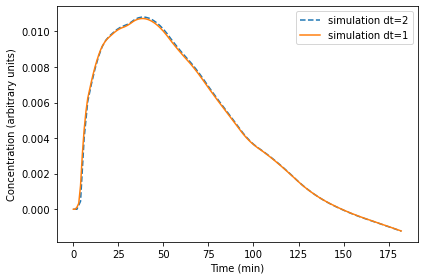

In [67]:
results.X.plot(style='--', label='simulation dt=2')
resultsn.X.plot(style='-', label='simulation dt=1')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

If we use run_simulation with smaller time steps, the results are more accurate, but they take longer to compute. For some problems, we can find a value of dt that produces accurate results in a reasonable time. However, if dt is too small, the results can be inaccurate again. So it can be tricky to get it right.

The advantage of run_solve_ivp is that it chooses the step size automatically in order to balance accuracy and efficiency. You can use keyword arguments to adjust this balance, but most of the time the results are accurate enough, and the computation is fast enough, without any intervention.

In [70]:
diff = results.X - resultsn.X
percent_diff = diff / resultsn.X * 100
percent_diff.abs().describe()

count     91.000000
mean       3.408303
std       12.574497
min        0.058578
25%        0.670081
50%        1.036680
75%        1.186027
max      100.000000
Name: X, dtype: float64

## Summary

In this chapter, we implemented the glucose minimal model two ways, using `run_simulation` and `run_solve_ivp`, and compared the results.
We found that in this example, `run_simulation`, which uses Euler's method, is probably good enough.
But soon we will see examples where it is not.

So far, we have assumed that the parameters of the system are known, but in practice that's not true.
As one of the case studies in the next chapter, you'll have a chance to see where those parameters came from.